# Leven at Newby Bridge using HBV model in eWaterCycle
This notebook demonstrates how eWaterCycle is used to run a model, in this case the classic HBV model, with forcing from the Caravan dataset. The only difference with the previous notebook is that here we use a "local" version of HBV, so HBV is not run inside of a container. This greatly speeds up the performance, but is less 'Reproducible' because now the results depend (more) on the setting / python version / dependcies of the local machine.

For this example, we chose a catchment in the Lake District in the UK. River discharge in river Leven is measured at the weirs at Newby Bridge, see the photo below. This observational data is available through the CamelsGB dataset [(Coxon, 2020)](https://essd.copernicus.org/articles/12/2459/2020/).
The larger [Caravan](https://www.nature.com/articles/s41597-023-01975-w) (collection of Camels...) dataset is available through eWaterCycle and will be used below.

![image](https://upload.wikimedia.org/wikipedia/commons/7/76/Weirs_on_the_River_Leven_at_Newby_Bridge_-_geograph.org.uk_-_5455774.jpg)

*Weirs on the River Leven at Newby Bridge by G Laird*

As a model we choose the classic [HBV model](https://hess.copernicus.org/articles/26/1371/2022/) for its simplicity. This nicely demonstrates how eWaterCycle works. More complex models are available through eWaterCycle, however:

- these often require parameter sets specific to a region
- these are more computationally intensive to run and therefore unsuited for a short 45 minute workshop.

Ask us about available models if you want to collaborate! 

### HBV model structure

The stucture of the HBV model is shown below.
Do note that the figure is missing a snow reservoir, however this has been implemented in the HBV model in this notebook.

![image](_images/model_layout.png)

*Image from the TU Delft course ENVM1502 - "River Basin Hydrology" by Markus Hrachowitz* 


## Starting up
To start up, we need to import eWaterCycle and a number of general Python libraries. 'Under the hood' eWaterCycle depends on a large number of other pieces of software, including but not limited to

- [grpc4bmi](https://github.com/eWaterCycle/grpc4bmi), a 'translator' for BMI function calls between different programming languages and across containers. This library was build by the eWaterCycle team, but is available openly for anyone that can benefit from its functionality. 
- apptainer, a container engine that runs the model-containers (Docker is supported too).
- [ESMValTool](https://github.com/ESMValGroup/ESMValTool), a climate data processing toolbox that originally intended to post-process climate data from CMIP projects for inclusion in IPCC reports, we adopted as tool for pre-processing climate data into forcing data for hydrological models
- Numerous hydrological models that are made available as plugins to eWaterCycle, see [eWaterCycle-leakybucket](https://github.com/eWaterCycle/ewatercycle-leakybucket) as an example. Note that plugins do not have to be owned and maintained by the eWaterCycle team: anyone with a model can make a plugin for eWaterCycle and make their model be available for others through the platform. 

Furthermore, eWaterCycle requires forcing data, obsrvational data and parameter sets to be available to users. If you want to install eWaterCycle on your own infrastructure, see the [eWaterCycle documentation](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) or contact us.

In [2]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print

#needed
from ipywidgets import IntProgress
from IPython.display import display

In [3]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

## Choose region and time period: 
The HBV model is a lumped hydrological model. It considers a catchment as a homogenious area and calculates the major hydrological processes in it. It requires spatially aggregated rainfall and potential evaporation as inputs (ie. forcings). To calculate its modelled discharge at the outlet of the catchment it also needs a set of parameters. Usually these paramters are calibrated using (historical) observational data, so this is also required. 

in eWaterCycle we provide access to the Caravan dataset, which contains all of the above data for all the catchments in the different Camels datasets. In this notebook we use the precipitation and evaporation data from Caravan. However, there is a known problem with the caravan evaporation data and (the current version) shouldn't be used. In this notebook we do so to demonstrate how it works. It would be better to generate forcing from (for example) ERA5. [This](example_model_run_HBV_camels_catchment_ERA5_forcing.ipynb) additional notebook that looks very similar to this one explains how to do that. 

Using the interactive maps at [eWaterCycle caravan map](https://www.ewatercycle.org/caravan-map/) one can easily retrieve the identifier of the catchment.

Note that changing the region below will work, but that the parameters that are loaded later in this notebook are calibrated specifically for this particular catchment!

In [4]:
camelsgb_id = "lamah_208082"

We have to specify start and end date of the experiment that we want to do. For now we don't fuzz with diverences between calibration and validation periods (which officially of course is very bad...)

In [5]:
experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2010-08-31T00:00:00Z"

calibration_start_time = experiment_start_date
calibration_end_time = experiment_end_date

## Set up paths

Since forcing files are often re-used between experiments it is a best practice to save those intermediate files for re-use between experiments. These logical save-points in workflows are called 'rustpunten' in Dutch. It is important to store data in 'rustpunten' in standard formats. Working with clearly defined 'rustpunten' is a key element in the design of good workflows in general and was instrumental in designing eWaterCycle in particular. 

Here we set up some paths to store the forcing files we generate in your own home directory. 

To speed up this workshop, we have already created the forcing files in a central location, which we also create pointers to here. If you want to run for a different region, you will have to generate the forcing yourself. 

In [6]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home()/ "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
#prepared_forcing_path_caravan_central = Path("~/forcing/camelsgb_73010/caravan")

## Generate or load forcing
There are three options for creating forcing data objects:

- generate from climate data such as Caravan, ERA5 or CMIP. Note that if the directory you specify as destination already contains data this trying this will throw an error!
- load forcing data you generated previously by providing the location where it was stored
- load forcing data someone else (such as your teacher or a workshop leader) generated previously by providing the location where it was stored

First we will create a caravan forcing object, but as mentioned above, we will only use this for the discharge observations and the shape file of the region. After generating the object we show the fields it contains and plot the discharge data. 

The actual forcing object we will use in this example is the ERA5 based data.

For both caravan and ERA5 based forcing, only one of the options provided below should be used, use comments to select which one you want to use.

In [7]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_caravan,
#     basin_id=camelsgb_id,
# )

In [8]:
# option two or three: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))


In [9]:
print(camelsgb_forcing)

CaravanForcing(
    start_time='1981-08-01T00:00:00Z',
    end_time='2010-08-31T00:00:00Z',
    directory=PosixPath('/home/thirza/forcing/lamah_208082/caravan'),
    shape=PosixPath('/home/thirza/forcing/lamah_208082/caravan/lamah_208082.shp'),
    filenames={
        'tas': 'lamah_208082_1981-08-01_2010-08-31_tas.nc',
        'tasmax': 'lamah_208082_1981-08-01_2010-08-31_tasmax.nc',
        'pr': 'lamah_208082_1981-08-01_2010-08-31_pr.nc',
        'Q': 'lamah_208082_1981-08-01_2010-08-31_Q.nc',
        'tasmin': 'lamah_208082_1981-08-01_2010-08-31_tasmin.nc',
        'evspsblpot': 'lamah_208082_1981-08-01_2010-08-31_evspsblpot.nc'
    }
)

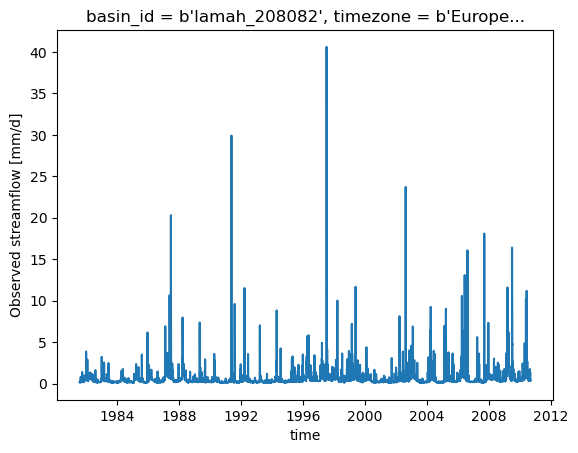

In [10]:
#quick plot of the discharge data. 
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q'],camelsgb_forcing['pr'],camelsgb_forcing['evspsblpot']])
ds_forcing["Q"].plot()

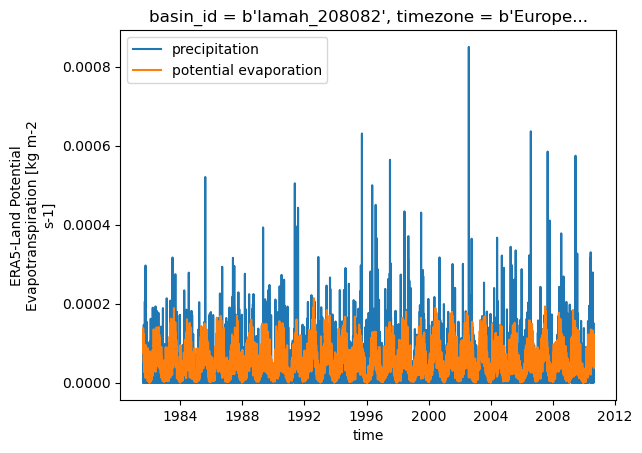

In [11]:
ds_forcing["pr"].plot(label = 'precipitation')
ds_forcing["evspsblpot"].plot(label = 'potential evaporation')
plt.legend()

## Load parameters from calibration

The HBV model contains five "stores" where the water is stored and nine parameters that control the flow between those stores and in and out of the model.
We have already calibrated the model for our region of choice and hardcoded those below. If you have changed the region and have calibrated for your region, you need to point to your calibration results here by uncommenting the load statement and pointing to the right file.

For the storages we can specify an array of starting values. If you don't the model will start 'empty' and needs some timesteps to 'fill up'. Especially for the rootzone storage it helps to not start empty. Note that all units are in mm: <br>

In [12]:
#we use the same initial conditions for all models in the ensemble

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Slowflow storage", "Groundwater storage"]

#the names of the parameters are (luckily ;-) ) also constant for all models
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]

In [13]:
#The number of ensemble members in our ensemble
N = 100

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,  .01])
# p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,  0.5])

p_min_initial= np.array([0,   0,  1,    0,   0,   0,     0,  0.0001,  0])
p_max_initial = np.array([50,    1.5,  3000,   30,    500,     50,    3,   3,  10])

parameters = np.zeros([9, N])

#here I use np.linspace to make a linear interpolation between the minimum and maximum parameters. Realize that this means that the first model will
#get all low parameters and the last model will get all high parameters. This can be done much smarter.
for param in range(9):
    parameters[param,:] = np.linspace(p_min_initial[param],p_max_initial[param],N)

In [14]:
# print(parameters.shape)  # Should be (expected_num_params, N)
# print(parameters)
# type(parameters)


In [15]:
# # Zelf: Random Grid Search
# import itertools
# N = 100
# parameters = np.zeros([9, N])
# ensemble = []
# combinaties = itertools.product(*parameters)
# for counter in range(N):
#     parameters[ = np.random.uniform(p_min_initial, p_max_initial)

#    # print(counter, ":", random_params)
#     if counter % 10 == 0:
#        print(counter)
    
#     ensemble.append(ewatercycle.models.HBVLocal(forcing=camelsgb_forcing))
#     config_file, _ = ensemble[counter].setup(
#                             parameters = random_params,
#                             initial_storage=s_0,
#                             cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
#                                )
#     ensemble[counter].initialize(config_file)

In [16]:
# # Zelf
# import itertools

# ensemble = []
# combinaties = itertools.product(*parameters)
# for counter, comb in enumerate(combinaties):
#     if counter % 10 == 0:
#         print(counter)
#     ensemble.append(ewatercycle.models.HBVLocal(forcing=camelsgb_forcing))
#     config_file, _ = ensemble[counter].setup(
#                             parameters = list(comb),
#                             initial_storage=s_0,
#                             cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
#                                )
#     ensemble[counter].initialize(config_file)

In [38]:
N = 50

parameters = np.random.uniform(p_min_initial[:, np.newaxis], p_max_initial[:, np.newaxis], (len(p_min_initial), N))
print(parameters)
parameters[4,:].min()
print(p_min_initial)

[[1.93309856e+01 4.97003094e+01 3.70054157e+01 4.42341395e+01
  1.17306448e+01 4.93149781e+01 2.21923816e+01 3.54758071e+01
  4.91227513e+01 2.65540167e+00 1.82826949e+01 9.41640209e+00
  3.58830220e+01 3.57497542e+01 4.54000506e+01 1.54060500e+01
  4.12883558e+01 1.31993049e+01 2.29439068e-01 3.28502433e+01
  4.88313157e+01 1.66913558e+01 1.65088662e+01 8.77737233e+00
  1.61762757e+00 1.65710694e+01 4.82261474e+01 4.23903365e+01
  3.28599109e+01 3.72344147e+01 2.98460216e+01 2.74199787e+01
  4.39156301e+01 4.41324008e+01 3.79096622e+01 4.84423691e+01
  3.80381000e+01 4.38037244e+01 4.24224752e+01 1.33055774e+01
  3.66575356e+01 4.52621913e+01 4.03608698e+01 4.99345256e+01
  2.99257749e+00 5.35037052e-01 2.80004820e+01 3.49990868e+01
  4.45723581e+01 5.63817315e+00]
 [1.28299788e+00 8.48184441e-01 1.49459864e+00 4.28366364e-01
  7.01865088e-01 4.74097922e-01 1.28646292e+00 1.35008160e+00
  8.10113150e-01 6.19418454e-01 5.51660595e-01 8.16253970e-01
  8.69936529e-01 8.19124328e-01 7.06161329e-01 2.86914639e-01
  3.32556288e-01 6.74981841e-01 9.01796901e-01 7.93418760e-01
  5.74803168e-01 5.24754328e-01 7.34418364e-01 1.42678446e+00
  3.04069361e-01 5.77966531e-01 2.06790353e-01 1.24493767e+00
  1.07516513e+00 8.82765209e-01 1.31716742e+00 6.24285126e-01
  1.20346887e+00 8.85956638e-01 4.57306699e-01 1.08649329e+00
  2.71104192e-01 1.41038267e+00 3.29896972e-01 7.01743196e-01
  6.98351587e-01 1.21846569e+00 3.47073919e-01 1.39694448e+00
  1.34837845e+00 7.90641391e-01 2.94646695e-01 1.18653959e+00
  9.20583716e-01 2.93846348e-01]
 [1.28741868e+03 2.23094227e+03 6.19753847e+02 2.60756177e+03
  2.73270910e+03 1.87171254e+03 2.55084213e+03 1.37335926e+03
  2.93799689e+03 9.20062528e+02 1.18146386e+02 1.41295322e+02
  1.53176878e+03 2.85205732e+02 7.21057553e+02 2.06532409e+03
  2.08073625e+03 2.75877992e+03 2.36429415e+03 1.19086609e+02
  4.94577335e+02 6.54436115e+02 6.93801629e+02 7.24306642e+02
  1.22970439e+03 2.74623822e+03 1.45504662e+03 1.98576171e+03
  2.80794137e+03 1.14382987e+03 2.99410046e+03 2.53296342e+03
  2.31669652e+03 3.56190251e+02 8.23051146e+02 4.24249462e+02
  8.12721833e+02 1.63202941e+03 5.62932886e+02 1.73555967e+03
  9.61652890e+02 2.33811967e+03 1.76401793e+03 2.83737319e+03
  7.95408722e+02 2.13422323e+03 2.23302799e+03 1.35603842e+03
  2.23238519e+03 1.86661939e+03]
 [3.97056220e+00 2.27478965e+01 1.43585460e+01 2.32344823e+01
  1.19653833e+01 2.16449108e+01 1.74760489e+01 2.86525887e+00
  1.20509245e+01 6.02897819e-01 2.04569473e+01 2.28786886e+01
  7.38495924e+00 2.78392500e+01 2.02439997e+00 2.96404845e+01
  8.17235048e+00 1.78914754e+01 1.26245854e+01 1.08745746e+01
  3.87727545e+00 1.21115146e+01 3.77390382e+00 2.89191990e+01
  2.38413217e+01 1.06343564e+01 1.97537235e+01 1.75293864e+01
  8.97902559e+00 9.32957728e+00 1.87350325e+01 1.28329288e+01
  1.89916808e+01 1.78716450e+01 2.00381693e+01 1.40213829e+01
  1.49380146e+01 2.44626566e+01 2.12058642e+01 1.64272019e+01
  2.52662474e+01 1.29485315e+01 1.00285911e+01 2.74283472e+01
  1.89582554e+01 1.21242716e+01 1.69534470e+00 1.12630667e+01
  2.98613721e+01 6.84595440e+00]
 [2.12722259e+00 3.49953185e+00 3.47555570e+00 3.35540229e+00
  1.27251234e+00 1.67075395e+00 1.99111319e+00 2.90783274e+00
  1.26287243e+00 1.15112785e+00 2.91793742e+00 1.87397770e+00
  3.66420432e+00 2.81560022e+00 2.34633546e+00 1.83077245e+00
  1.60348726e+00 3.07044234e+00 3.50116654e+00 2.34853060e+00
  2.43540863e+00 2.28068981e+00 2.61317584e+00 2.62478973e+00
  3.28762996e+00 2.50715920e+00 2.61343108e+00 3.10416428e+00
  3.58391322e+00 2.37839551e+00 3.55309799e+00 3.09187102e+00
  2.25840626e+00 2.92417266e+00 2.08718040e+00 2.86656357e+00
  2.40136480e+00 2.07975338e+00 3.74099902e+00 3.50407299e+00
  1.83374477e+00 2.88500947e+00 2.23916431e+00 2.17797539e+00
  3.23007016e+00 1.77624612e+00 2.61618420e+00 3.87412403e+00
  3.40651711e+00 2.08714458e+00]
 [2.97053051e+01 1.25853068e+01 2.80459065e+01 4.00056660e+01
  8.68302801e+00 2.94926886e+01 2.41642910e+01 1.8880

[0.e+00 2.e-01 4.e+01 5.e-01 1.e+00 1.e+00 1.e-02 1.e-04 1.e-02]

In [18]:
ensemble = []

# for counter in range(N): 
#     ensemble.append(ewatercycle.models.HBVLocal(forcing=camelsgb_forcing))
#     config_file, _ = ensemble[counter].setup(
#                             parameters = ','.join([str(p) for p in parameters[:,counter]]),
#                             initial_storage=','.join([str(s) for s in s_0]),
#                             cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
#                                )
#     ensemble[counter].initialize(config_file)

for counter in range(N): 
    ensemble.append(ewatercycle.models.HBVLocal(forcing=camelsgb_forcing))
    config_file, _ = ensemble[counter].setup(
                            parameters = parameters[:,counter],
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
                               )
    ensemble[counter].initialize(config_file)


# for counter in range(N): 
#     ensemble.append(ewatercycle.models.HBVLocal(forcing=camelsgb_forcing))
#     config_file, _ = ensemble[counter].setup(
#     parameters=list(parameters[:, counter]),  # Pass as a list
#     initial_storage=list(s_0),  # Pass as a list
#     cfg_dir=f"configFiles/hbv_ensembleMember_{counter}",
# )
#     ensemble[counter].initialize(config_file)

## Observations and objective function

We will compare each model output to observations and we need some sort of objective function to judge if the output is any good and thus determine which parameters are good for this region. I provide a basic (bad!) objective function here.

Here we define the objective function

In [19]:
def calibrationObjective(modelOutput, observation, start_calibration, end_calibration):
    # a function that takes in two dataFrames, interpolates the model output to the
    # observations and calculates the average absolute difference between the two.

    #combine the two in one dataFrame
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    #calculate mean absolute difference

    #diff = hydro_data['Q'] - hydro_data['model output']

    #in kwadaat zodat pieken zwaarder wegen
    diff = (hydro_data['Q'] - hydro_data['model output']) ** 4
    absDiff = np.abs(diff)
    meanAbsDiff = np.mean(absDiff)

    return meanAbsDiff
  

Now we run the entire ensemble. Note that in theory this loop can be run in parallel. If you have access to many core (or a supercomputer), this loop can be speed up considerably! For HBV this is not really a problem, but when doing calibration with larger models, this is a must.

In [20]:
#an object to show a progress bar, since this can take a while:
f = IntProgress(min=0, max=N) # instantiate the bar
display(f) # display the bar

#converting the observations to a pandas object, because Rolf is stupid
Q_pandas = ds_forcing["Q"].to_dataframe()
#an empty array to store the results in
objectives = []

#loop over all ensemble members
for ensembleMember in ensemble:
    Q_m = []
    time = []
    while ensembleMember.time < ensembleMember.end_time:
        ensembleMember.update()
        discharge_this_timestep = ensembleMember.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(ensembleMember.time_as_datetime.date()))

    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))
    objective_this_model = calibrationObjective(discharge_dataframe,Q_pandas["Q"],calibration_start_time,calibration_end_time)
    objectives.append(objective_this_model)

    #it is good practice to remove any variable you don't need anymore to save memory.
    del Q_m, time, discharge_dataframe, objective_this_model
   
    #update progress bar
    f.value += 1

# print(objectives)  

IntProgress(value=0, max=50)

/home/thirza/HBV-bmi/src/HBV/HBV_bmi.py:160: RuntimeWarning: invalid value encountered in scalar power
/home/thirza/HBV-bmi/src/HBV/HBV_bmi.py:160: RuntimeWarning: invalid value encountered in scalar power
/home/thirza/HBV-bmi/src/HBV/HBV_bmi.py:160: RuntimeWarning: invalid value encountered in scalar power


In [21]:
#beste 10% zoeken

n = int(len(objectives) * 0.1)

lowest_indices = np.argsort(objectives)[:n]  # Sorteert en pakt de eerste n indices
type(lowest_indices)

# Stap 3: Haal de bijbehorende arrays op uit data_matrix
lowest_arrays = parameters[:, lowest_indices]

objectives = np.array(objectives)
# Print resultaten
print("Laagste 10% waarden in objectives:\n", objectives[lowest_indices])
print("\nBijbehorende arrays uit data_matrix:\n", lowest_arrays)

# # Sorteer de lijst en pak de eerste n elementen
# lowest_10_percent = sorted(objectives)[:n]

# print(lowest_10_percent)

# best_parameters = parameters[:, lowest_10_percent]

Laagste 10% waarden in objectives:
 [299.03888472 376.30771092 381.32921225 384.99792675 385.07780478]

Bijbehorende arrays uit data_matrix:
 [[2.84330469e+01 4.07406679e+01 1.75505156e+01 1.92739944e+01
  1.53383266e+01]
 [5.90859874e-01 3.02710545e-01 1.34472660e-01 1.31456485e+00
  1.07104226e+00]
 [2.02130968e+03 1.69168336e+03 8.36649137e+02 2.21390569e+03
  1.72533508e+03]
 [3.16969572e+00 3.46741144e-02 4.38565601e+00 2.14671266e+01
  8.80994060e+00]
 [2.84400331e+02 3.08343876e+02 4.25951588e+02 4.30485123e+02
  2.07323216e+02]
 [7.77251821e-01 3.37383424e+01 4.00166902e+01 1.07844921e+01
  1.87516229e+01]
 [2.38107324e+00 2.05855559e+00 5.50417433e-02 2.59999788e+00
  4.39535106e-01]
 [4.02226000e-01 4.42462016e-01 2.97939999e+00 5.85839360e-02
  2.04401445e-01]
 [1.69030039e+00 9.47408649e+00 3.18034752e+00 6.63953920e+00
  4.32055864e+00]]

In [22]:
# Bereken de minimum en maximum waarden per rij
p_min_initial2 = np.min(lowest_arrays, axis=1)  # Kleinste per rij
p_max_initial2 = np.max(lowest_arrays, axis=1)  # Grootste per rij
print(p_min_initial2)

# Print resultaten
print("Minimumwaarden per rij:\n", p_min_initial2)
print("\nMaximumwaarden per rij:\n", p_max_initial2)

[1.53383266e+01 1.34472660e-01 8.36649137e+02 3.46741144e-02
 2.07323216e+02 7.77251821e-01 5.50417433e-02 5.85839360e-02
 1.69030039e+00]

Minimumwaarden per rij:
 [1.53383266e+01 1.34472660e-01 8.36649137e+02 3.46741144e-02
 2.07323216e+02 7.77251821e-01 5.50417433e-02 5.85839360e-02
 1.69030039e+00]

Maximumwaarden per rij:
 [4.07406679e+01 1.31456485e+00 2.21390569e+03 2.14671266e+01
 4.30485123e+02 4.00166902e+01 2.59999788e+00 2.97939999e+00
 9.47408649e+00]

In [36]:
N = 50

parameters2 = np.random.uniform(p_min_initial2[:, np.newaxis], p_max_initial2[:, np.newaxis], (len(p_min_initial2), N))
print(parameters2)

[[3.14104858e+01 1.78432208e+01 3.55635905e+01 4.04761028e+01
  3.35481960e+01 1.58993027e+01 3.69710343e+01 1.65627311e+01
  3.31234496e+01 1.90750841e+01 1.97437078e+01 2.57322335e+01
  3.24907844e+01 1.71856315e+01 1.61289068e+01 3.62127167e+01
  3.17475431e+01 3.22988223e+01 1.78773933e+01 2.06555227e+01
  2.13461614e+01 2.89619093e+01 2.31545866e+01 1.61625215e+01
  3.02192204e+01 2.63235833e+01 1.94847521e+01 2.32064793e+01
  2.19601082e+01 3.67215048e+01 2.26059299e+01 3.63885294e+01
  2.49801136e+01 1.87773221e+01 2.61374475e+01 3.03033100e+01
  3.38630500e+01 3.02799975e+01 3.72897533e+01 2.22439135e+01
  3.51503883e+01 3.18267924e+01 2.75980296e+01 4.07184661e+01
  3.43564074e+01 2.03095502e+01 2.28429775e+01 3.56793784e+01
  2.69532263e+01 3.89421903e+01]
 [4.69231444e-01 2.53472717e-01 1.14341268e+00 9.05185711e-01
  6.36142203e-01 7.38301489e-01 1.22842061e+00 9.13238329e-01
  1.25535443e+00 3.26912740e-01 5.52475330e-01 6.94372934e-01
  2.24762458e-01 3.50229194e-01 8.89435162e-01 1.11390743e+00
  9.88535283e-01 2.81730561e-01 6.78576562e-01 4.18472770e-01
  5.31044820e-01 7.47682267e-01 9.93444389e-01 7.18321750e-01
  5.92518602e-01 1.29871134e+00 7.02161521e-01 1.28708358e+00
  4.90860798e-01 1.05986901e+00 1.25610287e+00 1.06844096e+00
  7.05302593e-01 1.91541748e-01 4.33449326e-01 1.22287954e+00
  9.71606653e-01 3.51217456e-01 8.34529672e-01 1.31282657e+00
  1.09732191e+00 1.20343693e+00 1.66114679e-01 1.24224500e+00
  1.02246784e+00 7.77094247e-01 6.80272197e-01 1.39601693e-01
  5.31639042e-01 1.06431982e+00]
 [1.96285364e+03 2.11194585e+03 2.01603449e+03 9.09146392e+02
  1.64665997e+03 1.52313692e+03 1.98759208e+03 2.06209051e+03
  2.07208843e+03 1.93905162e+03 2.04204108e+03 1.01623759e+03
  1.55230853e+03 2.11335962e+03 1.79647442e+03 1.50795358e+03
  8.89421158e+02 8.49730919e+02 1.06283112e+03 2.12085964e+03
  1.33777957e+03 1.80178931e+03 2.06738056e+03 1.84253274e+03
  1.99868973e+03 1.87924252e+03 8.72359529e+02 1.24034068e+03
  9.73187940e+02 1.69898507e+03 1.18398468e+03 1.61610046e+03
  2.16622249e+03 2.04419760e+03 1.52505282e+03 1.75490105e+03
  2.08476316e+03 1.42277400e+03 2.19782589e+03 1.58677277e+03
  1.18364188e+03 9.34012331e+02 1.34531010e+03 1.61629131e+03
  9.50255449e+02 1.24902774e+03 1.43561008e+03 1.32578261e+03
  2.17975163e+03 1.62107802e+03]
 [5.97031545e+00 1.57505335e+00 4.56537925e+00 1.95233038e+01
  1.70759485e+00 5.44117127e+00 6.83476088e+00 1.00046110e+01
  6.72786061e+00 9.78519003e-01 5.41799485e+00 5.26306349e+00
  3.79810845e+00 6.12906416e-01 6.07177837e+00 1.15265311e+01
  4.75325093e+00 1.63560710e+01 4.79998539e+00 3.78476591e+00
  1.87208902e+01 8.06623745e+00 1.82255059e+01 7.04021316e+00
  9.28075508e+00 4.70772922e+00 2.22029215e+00 1.04197229e+01
  1.39372670e+01 1.23211502e+01 1.08466783e+01 1.19713514e+01
  3.48323365e+00 4.34249437e+00 2.77850146e-01 8.53447491e+00
  1.16477503e-01 2.70724581e+00 1.28709193e+01 5.91662196e+00
  8.06216279e+00 9.99649593e+00 1.88102842e+01 1.75197303e+01
  9.30239637e+00 1.76948089e+01 9.18898450e+00 1.32667087e+01
  1.62178954e+01 5.18082921e-02]
 [3.77734918e+02 2.88883193e+02 3.82451313e+02 3.21432064e+02
  3.52333998e+02 4.12922080e+02 2.70266882e+02 2.88706380e+02
  2.64525291e+02 3.01409789e+02 2.08333978e+02 2.32785376e+02
  3.17881914e+02 2.32777612e+02 4.23896336e+02 3.36642104e+02
  2.84291768e+02 3.22536932e+02 3.45331698e+02 3.60603352e+02
  2.44310624e+02 4.30413023e+02 2.48011472e+02 2.99141171e+02
  2.57391304e+02 4.05292055e+02 2.28259844e+02 3.26526589e+02
  2.29138517e+02 2.15030850e+02 2.35815754e+02 2.86066131e+02
  2.82649930e+02 2.37832633e+02 2.32439711e+02 3.77303034e+02
  2.32154596e+02 2.19770665e+02 4.15913697e+02 3.47668443e+02
  4.20760203e+02 4.00386198e+02 3.31738473e+02 2.34000802e+02
  3.59642958e+02 3.49215890e+02 3.21493722e+02 2.70412348e+02
  2.13214188e+02 2.33578737e+02]
 [1.37930298e+01 3.33149642e+01 1.12126074e+01 3.00830981e+01
  1.80229280e+01 3.73856384e+01 3.86900704e+01 2.4793

In [37]:
ensemble = []
for counter in range(N): 
    ensemble.append(ewatercycle.models.HBVLocal(forcing=camelsgb_forcing))
    config_file, _ = ensemble[counter].setup(
                            parameters2 = parameters2[:,counter],
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
                               )
    ensemble[counter].initialize(config_file)

ValueError: The model needs the parameters argument, consisting of 9 parameters;
   [Imax, Ce, Sumax, Beta, Pmax, Tlag, Kf, Ks, FM]

In [25]:
# #an object to show a progress bar, since this can take a while:
# f = IntProgress(min=0, max=N) # instantiate the bar
# display(f) # display the bar

# #converting the observations to a pandas object, because Rolf is stupid
# Q_pandas = ds_forcing["Q"].to_dataframe()

# #an empty array to store the results in
# objectives = []

# #loop over all ensemble members
# for ensembleMember in ensemble:
#     Q_m = []
#     time = []
#     while ensembleMember.time < ensembleMember.end_time:
#         ensembleMember.update()
#         discharge_this_timestep = ensembleMember.get_value("Q")
#         Q_m.append(discharge_this_timestep[0])
#         time.append(pd.Timestamp(ensembleMember.time_as_datetime.date()))

#     #calculate the objective function 
#     discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))
#     objective_this_model = calibrationObjective(discharge_dataframe,Q_pandas["Q"],calibration_start_time,calibration_end_time)
#     objectives.append(objective_this_model)

#     #it is good practice to remove any variable you don't need anymore to save memory.
#     del Q_m, time, discharge_dataframe, objective_this_model
   
#     #update progress bar
#     f.value += 1

In [26]:
# #beste 10% zoeken

# n = int(len(objectives) * 0.1)

# lowest_indices = np.argsort(objectives)[:n]  # Sorteert en pakt de eerste n indices
# type(lowest_indices)

# # Stap 3: Haal de bijbehorende arrays op uit data_matrix
# lowest_arrays = parameters[:, lowest_indices]

# objectives = np.array(objectives)
# # Print resultaten
# print("Laagste 10% waarden in objectives:\n", objectives[lowest_indices])
# print("\nBijbehorende arrays uit data_matrix:\n", lowest_arrays)

# # # Sorteer de lijst en pak de eerste n elementen
# # lowest_10_percent = sorted(objectives)[:n]

# # print(lowest_10_percent)

# # best_parameters = parameters[:, lowest_10_percent]

In [27]:
#finaly, just like before, we remove the models themselves to save up space and memory.
for ensembleMember in ensemble:
    ensembleMember.finalize()

## Analyse results
We now have objective function results for all ensemble members! Let's make some plots!

In [28]:
import matplotlib.pyplot as plt

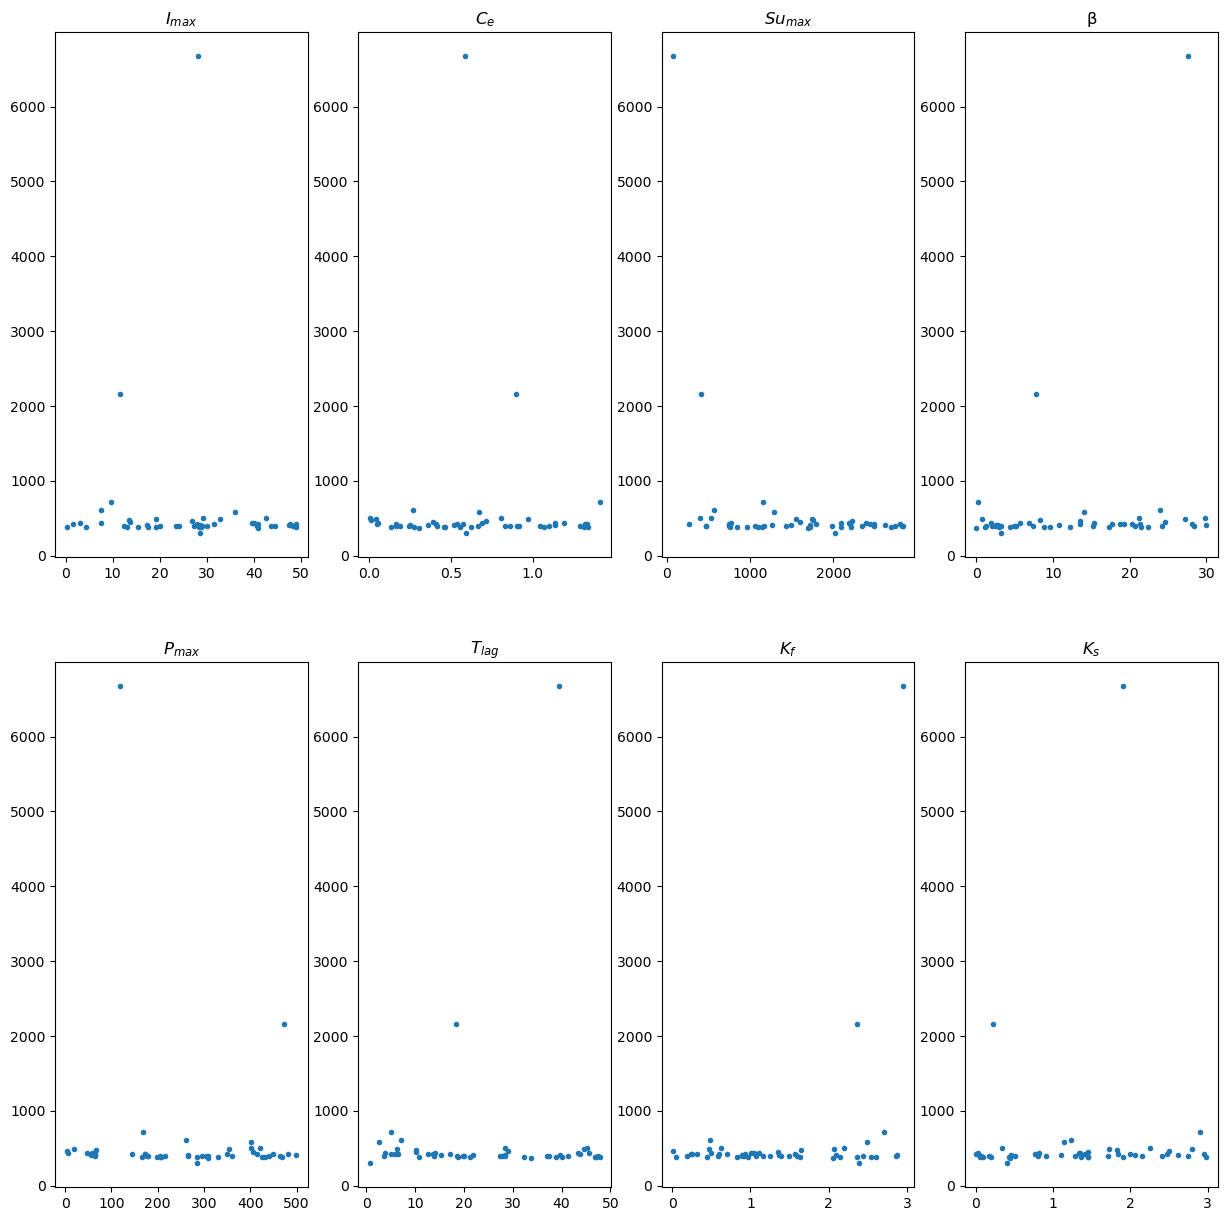

In [29]:
xFigNr = 2
yFigNr = 4

fig, axs = plt.subplots(xFigNr, yFigNr,figsize = (15,15))

for xFig in range(xFigNr):
    for yFig in range(yFigNr):
        paramCounter = xFig*yFigNr + yFig
        axs[xFig,yFig].plot(parameters[paramCounter,:],objectives,'.')
        axs[xFig,yFig].set_title(p_names[paramCounter])


In [30]:
#let's also show the minimal values:
parameters_minimum_index = np.argmin(np.array(objectives))

objective_minimum = np.min(objectives)

parameters_minimum = parameters[:,parameters_minimum_index]

print("Best parameter index:", parameters_minimum_index)
print("Best parameter set:", parameters_minimum)
print("Objective: ", objective_minimum)


Best parameter index: 19

Best parameter set: [2.84330469e+01 5.90859874e-01 2.02130968e+03 3.16969572e+00
 2.84400331e+02 7.77251821e-01 2.38107324e+00 4.02226000e-01
 1.69030039e+00]

Objective:  299.0388847225354

In [31]:
p_min_initial= np.array([0,   0.2,  40,    0.5,   1,   1,     0.01,  0.0001,  0.01])
p_max_initial = np.array([50,    1.5,  3000,   30,    4,     50,    3,   3,  7])